In [ ]:
#default_exp causal_model

# Causal Model
> Implementing instrumental variable and backdoor criteria plus propensity and regression methods

**Notes**

* Causal Bayesian Networkx: [here](http://conference.scipy.org/proceedings/scipy2015/pdfs/mike_pacer.pdf)

dowhy > causal_model.py CausalModel > causal_graph.py CausalGraph

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import dowhy as dw
from typing import List, Union
import networkx as nx
import itertools
import sympy as sp
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
import numpy as np
from scipy import stats

In [ ]:
plt.style.use('bmh')

In [ ]:
treatments = ['V0', 'V1']
outcome = 'Y'
common_causes = ['W0']
effect_modifiers = ['X0']
instruments = []
observed_nodes = treatments + [outcome] + instruments + effect_modifiers + common_causes
add_unobserved_confounder = True
missing_nodes_as_confounders = True

In [ ]:
cg_ref = dw.causal_graph.CausalGraph(treatments,
                                 [outcome], graph=None,
                                 common_cause_names=common_causes,
                                 instrument_names=instruments,
                                 effect_modifier_names=effect_modifiers,
                                 observed_node_names=observed_nodes)

In [ ]:
cg_ref._graph.nodes(data=True)

NodeDataView({'V0': {'observed': 'yes'}, 'V1': {'observed': 'yes'}, 'Y': {'observed': 'yes'}, 'W0': {'observed': 'yes'}, 'X0': {'observed': 'yes'}, 'U': {'label': 'Unobserved Confounders', 'observed': 'no'}})

In [ ]:
#export
class CausalGraph:
    def __init__(self, treatments:List[str], outcome:str='Y', 
                 common_causes:List[str]=None, effect_modifiers:List[str]=None,
                 instruments:List[str]=None, observed_nodes:List[str]=None, 
                 missing_nodes_as_confounders:bool=False,
                 add_unobserved_confounder:bool=True):
        if common_causes is None: common_causes = []
        if effect_modifiers is None: effect_modifiers = []
        if instruments is None: instruments = []
        if missing_nodes_as_confounders:
            all_passed_nodes = treatments + [outcome] + \
                common_causes + effect_modifiers + instruments
            missing_nodes = [node for node in all_passed_nodes if node not in observed_nodes]            
            common_causes = list(common_causes) + missing_nodes            
            
        self.g = self.create_nx_digraph(treatments, outcome, 
                                        common_causes, instruments, 
                                        effect_modifiers, add_unobserved_confounder)
        
    @staticmethod
    def create_nx_digraph(treatments:List[str], outcome:str, common_causes:List[str], 
                          instruments:List[str], effect_modifiers:List[str],
                          add_unobserved_confounder:bool=False):
        g = nx.DiGraph()
        g.add_edges_from([(treatment, outcome) for treatment in treatments])
        g.add_edges_from([(common_cause, treatment) 
                          for common_cause, treatment in itertools.product(common_causes, treatments)])
        g.add_edges_from([(common_cause, outcome) 
                          for common_cause in common_causes])
        g.add_edges_from([(effect_modifier, outcome) for effect_modifier in effect_modifiers])
        g.add_edges_from([(instrument, treatment) for instrument, treatment in itertools.product(instruments, treatments)])
        nx.set_node_attributes(g, True, 'observed')
        if add_unobserved_confounder:
            g.add_node('U', observed=False)
            g.add_edges_from([('U', treatment) for treatment in treatments])
            g.add_edge('U', outcome)
            
        return g


In [ ]:
cg = CausalGraph(treatments=treatments, outcome=outcome, common_causes=common_causes,
                 effect_modifiers=effect_modifiers, observed_nodes=observed_nodes,
                 missing_nodes_as_confounders=missing_nodes_as_confounders,
                 add_unobserved_confounder=add_unobserved_confounder)

In [ ]:
cg.g.nodes['U']['observed']

False

In [ ]:
#export
def show_graph(g:nx.Graph, kind:str='spectral'):
    try:
        layout = getattr(nx, f'{kind}_layout')(g)
    except AttributeError as ae:
        raise AttributeError(f'No nx.{kind}_layout found')
    nx.draw(g, layout=layout, with_labels=True)

def view_graph(self, kind:str='spectral'): 
    show_graph(self.g, kind=kind)

CausalGraph.view_graph = view_graph

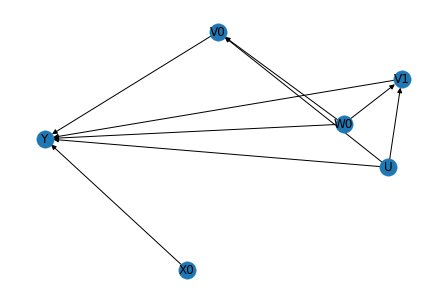

In [ ]:
cg.view_graph()

In [ ]:
#export
def get_ancestors(self, node:str, g:nx.DiGraph=None, 
                  parents_only:bool=False):
    if parents_only:
        f = self.g if g is None else g
        return f.predecessors(node)
    return nx.ancestors(self.g if g is None else g, node)

CausalGraph.get_ancestors = get_ancestors

In [ ]:
cg.get_ancestors('V0')

{'U', 'W0'}

In [ ]:
#hide
assert cg_ref.get_ancestors('V0') == cg.get_ancestors('V0')

In [ ]:
#export
def cut_edges(self, edges_to_cut:List[tuple]=None):
    if edges_to_cut is None: return None
    g_cut = self.g.copy()
    g_cut.remove_edges_from(edges_to_cut)
    return g_cut
        
CausalGraph.cut_edges = cut_edges

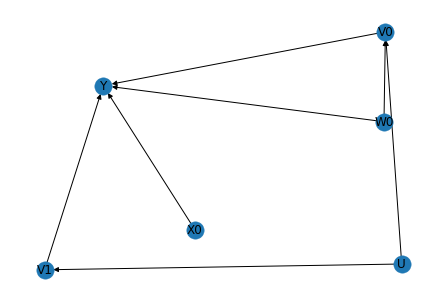

In [ ]:
g_cut = cg.cut_edges([('U','Y'), ('W0', 'V1')])
show_graph(g_cut)

In [ ]:
#hide
assert cg.cut_edges() is None

In [ ]:
#export
def get_causes(self, nodes:List[str], 
               edges_to_cut:List[tuple]=None):
    g_cut = self.cut_edges(edges_to_cut)
    causes = set()
    for node in nodes:
        causes.update(self.get_ancestors(node, g_cut))
    return causes

CausalGraph.get_causes = get_causes

In [ ]:
#hide
assert {'X0', 'U', 'W0', 'V0', 'V1'} == cg.get_causes(['Y'])
assert {'U', 'W0'} == cg.get_causes(['V0'])
assert cg_ref.get_causes(['Y']) == cg.get_causes(['Y'])
assert cg_ref.get_causes(['V0']) == cg.get_causes(['V0'])

In [ ]:
cg.get_causes(['V0'])

{'U', 'W0'}

In [ ]:
#export
def get_instruments(self, treatments:List[str], outcome:str):
    treatment_parents_edges = set()
    treatment_parents = set()
    for treatment in treatments:
        parents = self.get_ancestors(treatment, parents_only=True)
        treatment_parents.update(parents)
        treatment_parents_edges.update([(parent, treatment) 
                               for parent in parents])
    
    g_cut = self.cut_edges(treatment_parents_edges)
    
    outcome_ancestors = self.get_ancestors(outcome, g_cut)
    
    instruments_candidates = treatment_parents.difference(outcome_ancestors)
    
    descendants = set()
    for parent in outcome_ancestors:
        descendants.update(nx.descendants(g_cut, parent))
    instruments = instruments_candidates.difference(descendants)
    return instruments

CausalGraph.get_instruments = get_instruments

In [ ]:
cg.get_instruments(treatments, outcome)

In [ ]:
#hide
assert set(cg_ref.get_instruments(treatments, [outcome])) == set(cg.get_instruments(treatments, outcome))

In [ ]:
#export
def get_effect_modifiers(self, treatments:List[str], outcomes:List[str]):
    modifiers = set()
    for outcome in outcomes:
        modifiers.update(self.get_ancestors(outcome))
    modifiers = modifiers.difference(treatments)
    for treatment in treatments:
        modifiers = modifiers.difference(self.get_ancestors(treatment))
    return list(modifiers)
    
CausalGraph.get_effect_modifiers = get_effect_modifiers

In [ ]:
cg.get_effect_modifiers(treatments, [outcome])

['X0']

In [ ]:
#hide
assert set(cg_ref.get_effect_modifiers(treatments, [outcome])) == set(cg.get_effect_modifiers(treatments, [outcome])), f'{effect_modifiers} != {cg.get_effect_modifiers(treatments, [outcome])}'

In [ ]:
#export
class CausalModel:
    
    def __init__(self, treatments:List[str], outcome:str='Y',
                 common_causes:List[str]=None, effect_modifiers:List[str]=None,
                 instruments:List[str]=None, causal_graph_kwargs=None):
        if not causal_graph_kwargs: causal_graph_kwargs = dict()
        self.cg = CausalGraph(treatments, outcome, 
                              common_causes=common_causes,
                              effect_modifiers=effect_modifiers, 
                              instruments=instruments, 
                              **causal_graph_kwargs)
        self.treatments = treatments
        self.outcome = outcome
        self.common_causes = common_causes
        self.effect_modifiers = effect_modifiers
        self.instruments = instruments
        
    def identify_effect(self):
        pass
    def estimate_effect(self):
        pass
    def refute_estimate(self):
        pass

In [ ]:
treatments = ['V0', 'V1']
outcome = 'Y'
common_causes = ['W0']
effect_modifiers = ['X0']
instruments = []
observed_nodes = treatments + [outcome] + instruments + effect_modifiers
add_unobserved_confounder = True
missing_nodes_as_confounders = True

cg_kwargs = dict(
    missing_nodes_as_confounders=missing_nodes_as_confounders,
    add_unobserved_confounder=add_unobserved_confounder,
    observed_nodes=observed_nodes
)

In [ ]:
cm = CausalModel(treatments=treatments, outcome=outcome, common_causes=common_causes,
                 effect_modifiers=effect_modifiers,
                 causal_graph_kwargs=cg_kwargs)

In [ ]:
#export
def identify_effect(self, estimand_type:str='nonparametric-ate'):
    causes = {
        'treatments': self.cg.get_causes(self.treatments),
        'effects': self.cg.get_causes([self.outcome], 
                                      edges_to_cut=[(t, self.outcome) for t in self.treatments])
    }
    print(f'causes: {causes}')
    common_causes = causes['treatments'].intersection(causes['effects'])
    print(f'common causes: {common_causes}')
    
    instruments = self.cg.get_instruments(self.treatments, self.outcome)
    
    # constructing backdoor estimand
    backdoor = self.construct_backdoor(self.treatments, self.outcome,
                                       common_causes, estimand_type=estimand_type)
    print('Backdoor:', backdoor)
    
    # constructing instrumental variable estimand
    instrumental_variable = None
    if len(instruments) > 0:
        instrumental_variable = self.construct_instrumental_variable(treatments, outcome, instruments,
                                                                 estimand_type=estimand_type)
    
    print('Instrumental variable:', instrumental_variable)
    return {
        'observed_common_causes': common_causes,
        'backdoor': backdoor,
        'instrumental_variable': instrumental_variable
    }
    
def construct_backdoor(self, treatments:List[str], outcome:str, 
                       common_causes:List[str], 
                       estimand_type:str='nonparametric-ate'):
    
    if estimand_type != 'nonparametric-ate': raise NotImplementedError
    
    # treatment variables
    sym_treatments = sp.Array([sp.Symbol(treatment) for treatment in treatments])
    
    # outcome given common causes
    expr = f'{outcome} | {",".join(common_causes)}' \
        if len(common_causes) > 0 else outcome  
    
    # assigning a normal distribution to the outcome given common causes
    sym_mu = sp.Symbol("mu")                                                                           
    sym_sigma = sp.Symbol("sigma", positive=True)
    sym_outcome = sp.stats.Normal(expr, sym_mu, sym_sigma)
    # expected outcome given common causes
    sym_conditional_outcome = sp.stats.Expectation(sym_outcome) 
    
    # effect of treatment on outcome given common causes
    sym_effect = sp.Derivative(sym_conditional_outcome, sym_treatments) 
    return sym_effect

def construct_instrumental_variable(self, treatments:List[str], outcome:str, 
                                    instruments:List[str], estimand_type:str='nonparametric-ate'):
    
    if estimand_type != 'nonparametric-ate': raise NotImplementedError
    
    sym_mu, sym_sigma = 0, 1
    sym_outcome = sp.stats.Normal(outcome, sym_mu, sym_sigma)
    sym_treatments = sp.Array([sp.Symbol(sp.stats.Normal(treatment, sym_mu, sym_sigma)) 
                              for treatment in treatments])
    sym_instruments = sp.Array([sp.Symbol(instrument) 
                                for instrument in instruments])
    sym_effect = sp.stats.Expectation(
        sp.Derivative(sym_outcome, sym_instruments) 
        / 
        sp.Derivative(sym_treatments, sym_instruments)
    )
    
    return sym_effect

CausalModel.construct_backdoor = construct_backdoor
CausalModel.construct_instrumental_variable = construct_instrumental_variable
CausalModel.identify_effect = identify_effect

In [ ]:
estimands = cm.identify_effect(); estimands

causes: {'treatments': {'U', 'W0'}, 'effects': {'U', 'X0', 'W0'}}
common causes: {'U', 'W0'}
Backdoor: Derivative(Expectation(Y | U,W0), [V0, V1])
Instrumental variable: None


{'observed_common_causes': {'U', 'W0'},
 'backdoor': Derivative(Expectation(Y | U,W0), [V0, V1]),
 'instrumental_variable': None}

Regression estimators based on sklearn regression classes

In [ ]:
isinstance(linear_model.LinearRegression(), sklearn.base.RegressorMixin)

True

In [ ]:
#export
class RegressionEstimator:
    
    def __init__(self, model:sklearn.base.RegressorMixin):
        assert isinstance(model, sklearn.base.RegressorMixin)
        self.m = model
        
    def fit(self, X:np.ndarray, y:np.ndarray, ix:int, ix_confounders:List[int], reset:bool=True):
        if not isinstance(ix_confounders, list):
            ix_confounders = list(ix_confounders)
        self.ix = ix
        self.ix_confounders = ix_confounders
        _ix = [ix] + ix_confounders
        self._ix = _ix
        if reset:
            self.m.fit(X[:,self._ix],y)
            
    def estimate_effect(self, X:np.ndarray, treatment:Union[int, float], control:Union[int, float]):
        n, _ = X.shape
        _X = X.copy()
        _X[:, self.ix] = treatment
        
        treatment_outcomes = self.m.predict(_X[:, self._ix])
        _X[:, self.ix] = control
        control_outcomes = self.m.predict(_X[:, self._ix])
        
        treatment_mean = treatment_outcomes.mean()
        control_mean = control_outcomes.mean()
        ate = treatment_mean - control_mean
        
        return ate

Sanity checking on a quadratic polynomial toy dataset

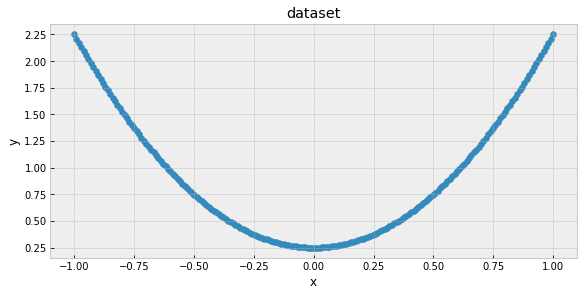

In [ ]:
X = np.linspace(-1, 1, 200)
X = np.array([X**2, X, np.ones(len(X))*.5]).T
w = np.array([2, 0, .5])
y = X @ w

fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
ax.scatter(X[:,-2], y)
ax.set(xlabel='x', ylabel='y', title='dataset')
plt.show()

In [ ]:
regression_model = linear_model.LinearRegression()
estimator = RegressionEstimator(regression_model)
estimator.fit(X, y, ix=0, ix_confounders=[1])
ate = estimator.estimate_effect(X=X, treatment=1, control=0)
print(f'ate = {ate:.3f} coefs {estimator.m.coef_}')

ate = 2.000 coefs [ 2.00000000e+00 -1.27928927e-17]


In [ ]:
#hide
assert np.isclose(ate, w[0], atol=.1)

Classification estimator

propensity score: common causes -> prediction of treatment (class) -> grouping by score to select pairs of most similar treatment and control group samples to compute the difference in outcome

grouping is done using some nearest neighbour search:
- ATC if nearest neighbor is set up with the **treated** group and for each **control** group sample a match is looked up and then the difference of the outcome is computed
- ATT if nearest neighbor is set up with the **control** group and for each **treated** group sample a match is looked up and then the difference of the outcome is computed

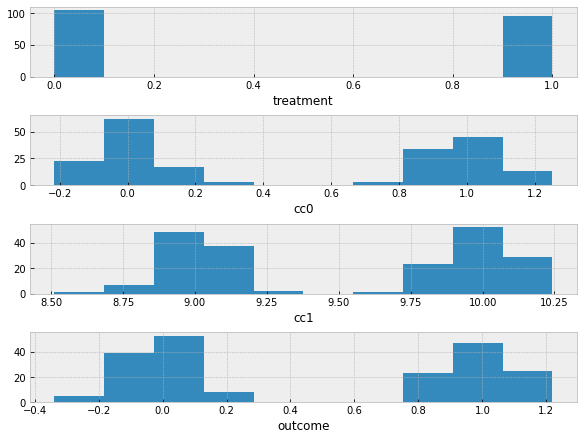

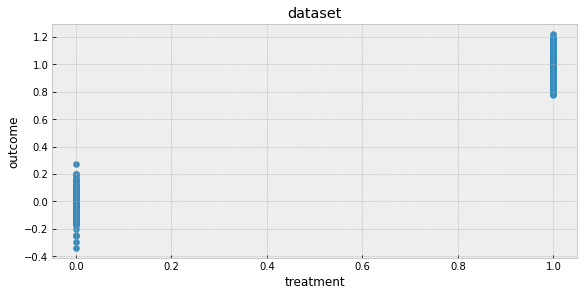

In [ ]:
n = 200
x_treatment = np.random.choice([True, False], p=[.5, .5], size=n)
x_common_causes = np.array([
    [np.random.normal(loc=v, scale=.1) for v in x_treatment],
    [np.random.normal(loc=10-v, scale=.1) for v in x_treatment],
])

y_outcome = np.array([np.random.normal(loc=v, scale=.1) for v in x_treatment])

fig, axs = plt.subplots(figsize=(8,6), nrows=4, constrained_layout=True)
axs[0].hist(x_treatment.astype(float))
axs[0].set(xlabel='treatment')
axs[1].hist(x_common_causes[0])
axs[1].set(xlabel='cc0')
axs[2].hist(x_common_causes[1])
axs[2].set(xlabel='cc1')
axs[3].hist(y_outcome)
axs[3].set(xlabel='outcome')
plt.show()

fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
ax.scatter(x_treatment, y_outcome)
ax.set(xlabel='treatment', ylabel='outcome', title='dataset')
plt.show()

X, y = np.concatenate((x_treatment[:,None], x_common_causes.T), axis=1), y_outcome
X.shape, y.shape

In [ ]:
from sklearn import neighbors

In [ ]:
class PropensityScoreMatcher:
    
    def __init__(self, propensity_model:sklearn.base.ClassifierMixin):
        assert isinstance(propensity_model, sklearn.base.ClassifierMixin)
        self.pm = propensity_model
        
    def fit(self, X:np.ndarray, y:np.ndarray, ix:int, ix_confounders:List[int], reset:bool=True):
        '''building the classifier model & nearest neigbhor search thingy
        
        ix: needs to point to a binary variable
        '''
        if not isinstance(ix_confounders, list):
            ix_confounders = list(ix_confounders)
        self.ix = ix
        self.ix_confounders = ix_confounders

        _ix = [ix] + ix_confounders
        self._ix = _ix
        if reset:
            self.pm.fit(X[:, self.ix_confounders], X[:,self.ix])
                     
    def estimate_effect(self, X:np.ndarray, y:np.ndarray, treatment:Union[int, bool], control:Union[int, bool],
                        kind:str='ate'):
        
        assert kind in ['ate', 'att', 'atc']
        propensity_score = self.pm.predict(X[:, self.ix_confounders])
        ix_treat, ix_control = X[:,self.ix] == treatment, X[:,self.ix] == control
        
        X_treat, X_cont = X[ix_treat,:], X[ix_control,:]
        y_treat, y_cont = y[ix_treat], y[ix_control]
        
        searcher = neighbors.NearestNeighbors(n_neighbors=1)
        
        def get_att():
            searcher.fit(propensity_score[ix_control][:,None])
            distances, indices = searcher.kneighbors(propensity_score[ix_treat][:,None])
            
            att = 0
            n_treat = ix_treat.sum()
            for i in range(n_treat):
                out_treat = y_treat[i]
                out_cont = y_cont[indices[i][0]]
                att += out_treat - out_cont
            return att / n_treat
        
        def get_atc():
            searcher.fit(propensity_score[ix_treat][:,None])
            distances, indices = searcher.kneighbors(propensity_score[ix_control][:,None])
            
            atc = 0
            n_cont = ix_control.sum()
            for i in range(n_cont):
                out_treat = y_treat[indices[i][0]]
                out_cont = y_cont[i]
                atc += out_treat - out_cont
            return atc / n_cont
        
        def get_ate():
            n_treat = ix_treat.sum()
            n_cont = ix_control.sum()
            att = get_att()
            atc = get_atc()
            return (att*n_treat + atc*n_cont) / (n_treat + n_cont)
        
        if kind == 'att':
            return get_att()
        elif kind == 'atc':
            return get_atc()
        elif kind == 'ate':
            return get_ate()
        else:
            raise NotImplementedError

In [ ]:
propensity_model = linear_model.LogisticRegression(solver='lbfgs')
estimator = PropensityScoreMatcher(propensity_model)
estimator.fit(X, y, ix=0, ix_confounders=[1, 2])
ate = estimator.estimate_effect(X=X, y=y, treatment=True, control=False)
print(f'ate = {ate:.3f}')

ate = 0.934


Generating data for the graphical model using `bcg.basics` functions

In [ ]:
from bcg.basics import CommonCauses, Instruments, EffectModifiers, Treatments, Outcomes, get_Xy
import pandas as pd

In [ ]:
outcome_is_binary = False

n = 333
n_common_causes = len(common_causes)
n_instruments = len(instruments)
n_eff_mods = len(effect_modifiers)
n_treatments = len(treatments)
beta = 1  # max random value

cc = CommonCauses.get_obs(n, n_common_causes)
ins = Instruments.get_obs(n, n_instruments)
em = EffectModifiers.get_obs(n, n_eff_mods)
treat = Treatments.get_obs(n, n_treatments, cc, ins, beta)
out = Outcomes.get_obs(treat, cc, em, outcome_is_binary=outcome_is_binary)
obs = pd.concat((treat.obs, cc.obs, em.obs, ins.obs, out.obs), axis=1)
X, y, not_target = get_Xy(obs, target=outcome)

In [ ]:
obs.head()

,V0,V1,W0,X0,Y
0,-2.062174,0.101653,0.436554,1.178004,-2.000886
1,-0.427900,1.065733,0.469966,-2.688262,1.289903
2,-0.129719,0.774790,0.020602,0.415508,0.629129
3,0.619531,0.667485,1.157490,-2.368033,1.028694
4,-1.534733,-0.980660,-0.784079,0.140463,-2.551118


In [ ]:
not_target.index('V0')

Adding effect estimate functionality to `CausalModel`

Changing the implementation of `get_Xy`, incorporating products with effect modifiers, based on lns 59-71 in `causal_estimators/linear_regression_estimator.py` with the new argument`feature_product_groups`. The variable is supposed to consist of two lists, each containing features in `obs`, of which all products will be computed.

In [ ]:
#export 
def get_Xy(obs:pd.DataFrame, target:str='Y', feature_product_groups:List[list]=None):
    'feaure_product_groups (e.g. [["V0", "V1", "W0"], ["X0", "X1"]]) to compute products between each var in the first and second list (not within each list)'
    not_target = [c for c in obs.columns if c != target and c not in feature_product_groups[1]]
#     out_cols = [col for col in obs.columns if col != target ]
    
    X, y = obs.loc[:, not_target].values, \
           obs.loc[:, target].values.ravel()
    if feature_product_groups:
        assert isinstance(feature_product_groups, list)
        assert len(feature_product_groups) == 2
        assert all([isinstance(f, list) for f in feature_product_groups])
        product_cols = [(t,e) for t,e in itertools.product(*feature_product_groups)]
        cols = list(obs.columns.values)
        for t, e in product_cols:
            ix_t = cols.index(t)
            ix_e = cols.index(e)
            x = (obs[t] * obs[e]).values
            X = np.concatenate((X, x[:,None]), axis=1)
            not_target.append(f'{t}_{e}')
    return X, y, not_target

In [ ]:
get_Xy(obs, target=outcome, feature_product_groups=[treatments, effect_modifiers])

(array([[-2.06217367,  0.10165321,  0.43655352, -2.42924804,  0.11974785],
        [-0.42790025,  1.0657328 ,  0.46996561,  1.15030778, -2.86496848],
        [-0.12971905,  0.77479028,  0.02060249, -0.05389931,  0.32193163],
        ...,
        [-0.70966697, -2.32796402,  2.20724734,  1.55402541,  5.09776475],
        [-0.25905595,  0.65131404, -1.21140486, -0.27757741,  0.69788037],
        [-2.00116322,  1.11825031, -0.59807879, -0.70160665,  0.3920579 ]]),
 array([-2.00088554e+00,  1.28990295e+00,  6.29129211e-01,  1.02869396e+00,
        -2.55111836e+00, -3.51175561e+00,  1.20114004e+00,  3.42398321e+00,
        -2.03925649e-01, -3.17895805e-01, -4.86210253e-01,  2.67238977e+00,
        -1.98586261e+00, -1.47312630e-01, -2.35017626e+00,  1.57634593e+00,
        -7.98529682e-03,  2.03960993e+00, -2.97333989e-02,  1.99258422e+00,
        -1.95795397e+00, -3.15112426e+00,  2.08422323e-01, -2.56672731e+00,
         1.90783941e-01, -1.54400188e+00,  3.54015014e-01, -1.84158445e+00,
   

In [ ]:
#hide
X, y, not_target = get_Xy(obs, target=outcome, feature_product_groups=[treatments, effect_modifiers])
assert y.shape[0] == X.shape[0]
assert X.shape[1] == len(not_target)
n_not_target = len(not_target)
rest_cols = [v for v in obs.columns.values if v not in effect_modifiers and v != outcome]
n_not_target_ideal = len(treatments) * len(effect_modifiers) + len(rest_cols)
assert len(not_target) == n_not_target_ideal, f'{n_not_target} != {n_not_target_ideal}: not_target = {not_target}'

In [ ]:
#export
def estimate_effect(self, estimands:dict, control_value:float, 
                    treatment_name:str, treatment_value:float, 
                    obs:pd.DataFrame, outcome:str='Y',
                    causal_method:str='backdoor',
                    model:Union[sklearn.base.RegressorMixin,]=None, target_unit:str='ate', 
                    effect_modifiers:List[str]=None):
    assert causal_method in {'backdoor', 'instrumental_variable'}
    assert target_unit == 'ate'
    
    if model is None:
        model = linear_model.LinearRegression()        
    
    if effect_modifiers is None:
        effect_modifiers = self.effect_modifiers
            
    # decide on approach given causal_method and model_type
    
    # estimate the effect using the arrived on approach
    X, y, not_outcome = get_Xy(obs, target=outcome, feature_product_groups=[treatments, effect_modifiers])
    estimator = RegressionEstimator(model)
    ix = [v.lower() for v in not_outcome].index(treatment_name)
    confounders = self.treatments + list(estimands['observed_common_causes']) + effect_modifiers
    print('confounders', confounders)
    ix_confounders = [_i for _i,_v in enumerate(obs.columns.values) if _v in confounders]
    estimator.fit(X, y, ix, ix_confounders)
    effect = estimator.estimate_effect(X=X, treatment=treatment_value, control=control_value)
    return effect

CausalModel.estimate_effect = estimate_effect

In [ ]:
causal_method = 'backdoor'
control_value = 0
treatment_name = 'v0'
treatment_value = 2

effect_modifiers = effect_modifiers
target_unit = 'ate'

model = linear_model.LinearRegression()

cm.estimate_effect(estimands, control_value, treatment_name, treatment_value,
                   obs, outcome=outcome, causal_method=causal_method, model=model,
                   target_unit=target_unit, effect_modifiers=effect_modifiers)

confounders ['V0', 'V1', 'U', 'W0', 'X0']


In [ ]:
a = np.linspace(1, 4, 5)
b = a[:, np.newaxis]; b